In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from fastai.vision.all import *
from pathlib import Path
import numpy as np
from PIL import Image
import torch

# Setting paths to dataset
path = Path('/content/drive/MyDrive/archive (3)')

image_path = path/'dataset/semantic_drone_dataset/original_images'
mask_path = path/'RGB_color_image_masks/RGB_color_image_masks'
csv_path = path/'class_dict_seg.csv'

In [ ]:
df = pd.read_csv(csv_path)
print("Columns in your CSV file:")
print(df.columns)

Columns in your CSV file:
Index(['name', ' r', ' g', ' b'], dtype='object')


In the above output, 'name' is the column for all the categories of obstacles present in the image segmentation. r, g, and b serve as the rgb codes for a particular obstacle.

In [ ]:
codes = df['name'].tolist()  # Making a list of all the obstacle categories
print(f"Loaded {len(codes)} categories: {codes}")
IGNORE_INDEX = 255
print(f"Defined IGNORE_INDEX for unmapped pixels: {IGNORE_INDEX}")
# Dictionary to make key - value pairs of rgb codes and obstacle categories
color_to_idx = {
    (row[' r'], row[' g'], row[' b']): i
    for i, row in df.iterrows()
}

Loaded 24 categories: ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']
Defined IGNORE_INDEX for unmapped pixels: 255


Next, we are going to create a function that locates the corresponding mask for an image, creates a label array that holds the class index corresponding to the pixel-wise matching color in the mask, and returns this as a TensorMask for use in segmentation.

In [ ]:
def get_y(fn):
    fn = mask_path / f"{fn.stem}.png"
    img = PILImage.create(fn)  # Creating a PILImage so it is convenient to convert it to a NumPy array.

    mask_array = np.array(img)
    # Empty label array, same size as the mask. We will overwrite the pixels we recognize with their correct class index.
    labels = np.full(mask_array.shape[:2], IGNORE_INDEX, dtype=np.int64)

    # For each known color in the mask, find all the pixels that match it, and mark those in the label map with the class number.
    for color, idx in color_to_idx.items():
        match = np.all(mask_array == np.array(color), axis=-1)
        labels[match] = idx

    # Sanity check to ensure there are no labels that the dataset doesn't recognize.
    unique_labels = np.unique(labels)
    out_of_bounds = unique_labels[unique_labels >= len(codes)]
    if out_of_bounds.size > 0:
        print(f"\n⚠️  WARNING: Mask {fn.name} contains out-of-bounds labels: {out_of_bounds}")
        print(f"Check that all colors in the mask exist in the CSV class dictionary.\n")

    return TensorMask(labels)

Now, let's make our DataBlock to prepare for segmentation.

I started by resizing the images to 128 because I was curious about the kind of results I would get. I want to see everytime I resize up from 128, what changes the model would have in its learning process.

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Saving 20% for validation
    get_y=get_y,
    item_tfms=Resize(128, method='pad', pad_mode='zeros'),
    batch_tfms=[IntToFloatTensor()]  # Converts image to float + normalize
)

dls = dblock.dataloaders(image_path, bs=4)


Taking a look at a sample batch

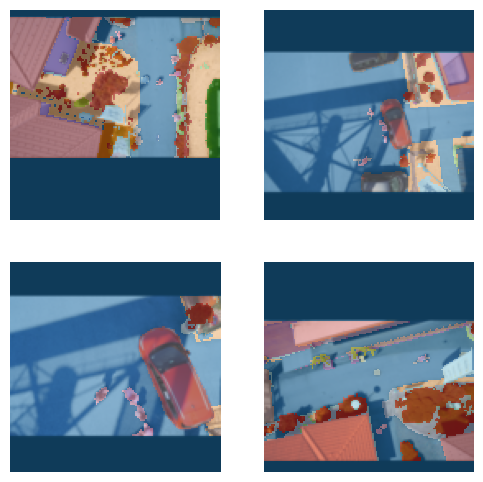

In [ ]:
dls.show_batch(max_n=6, vmin=0, vmax=len(codes)-1)

For this project, I picked resent34 a my model.

I also picked Cross Entropy Loss as the loss function of choice because it measures how well the predicted probability distribution matches the true class at each pixel. Here is how it is calculated:
$$-Σ^C_{c=1}y_clog(p̂_c)$$
Where:


*   C = number of classes
*   $y_c$ = 1 if pixel belongs to class c, else 0
*   $p̂_c$ =  predicted probability for class c at that pixel


My metrix of choice is Dice, which measures the overlpa between prediction and ground truth masks. Here is how it is calculated:
$$Dice = \frac{2 × |A∩B|}{|A| + |B|}$$
Where:


*   $A$ = Set of pixels predicted in a class
*   $B$ = Set of pixels that are actually in that class
*   $|A∩B|$ = Number of pixels correctly predicted








In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(ignore_index=IGNORE_INDEX, flatten=False), metrics=Dice())
learn.model = learn.model.cuda()
learn.dls.device = torch.device('cuda')

learn.fine_tune(3)

epoch,train_loss,valid_loss,dice,time
0,1.407374,1.232431,3.570248,16:03


epoch,train_loss,valid_loss,dice,time
0,1.175144,1.063344,3.576315,16:06
1,0.925166,0.853345,5.342142,16:10
2,0.785682,0.800593,5.808689,16:00


I trained for 3 epochs at first to see results. As you can see below, they were extremly garbled, and given the low dice, train_loss, and valid_loss scores, I figured I need to train the model more.

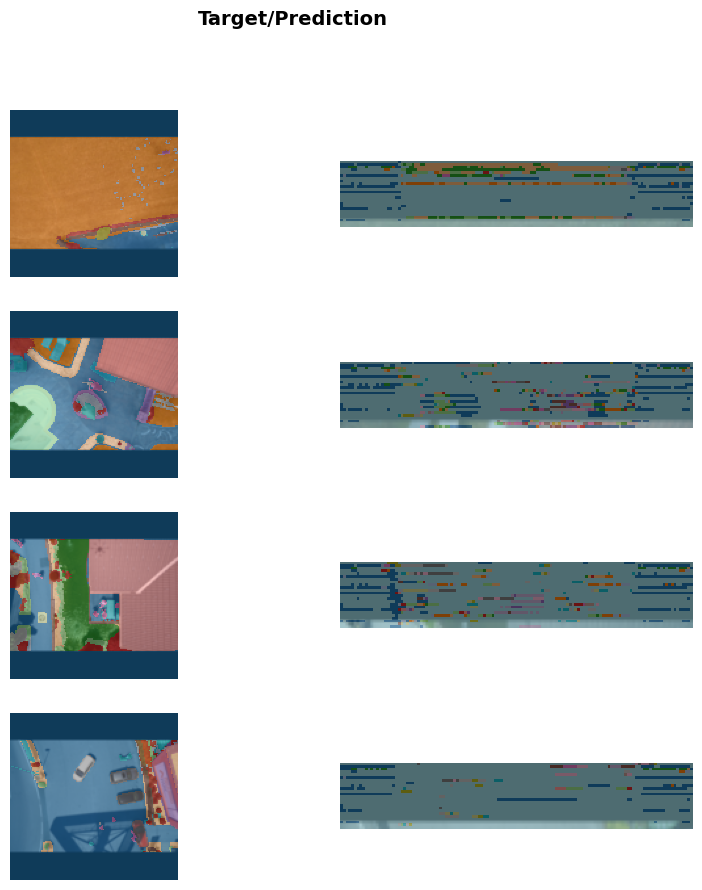

In [ ]:
learn.show_results(max_n=4, figsize=(10, 10))

In [ ]:
# Created a similar DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_y,
    item_tfms=Resize(128, method='pad', pad_mode='zeros'),
    batch_tfms=[IntToFloatTensor()]  # Converts image to float + normalize
)

dls = dblock.dataloaders(image_path, bs=4)


In [ ]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(ignore_index=IGNORE_INDEX, flatten=False), metrics=Dice())
learn.model = learn.model.cuda()
learn.dls.device = torch.device('cuda')

# Training for 8 epochs this time.
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 112MB/s]


epoch,train_loss,valid_loss,dice,time
0,1.399232,1.104620,3.720085,16:07


epoch,train_loss,valid_loss,dice,time
0,0.921806,0.952646,5.678688,16:03
1,0.887761,0.860913,5.585782,15:58
2,0.850386,0.883924,6.532150,16:08
3,0.805889,0.769163,7.174032,16:04
4,0.731509,0.752766,7.214015,15:59
5,0.650617,0.676434,7.171861,15:59
6,0.590825,0.669244,7.135864,16:04
7,0.552427,0.657869,7.354560,16:02


Saw improvement in loss scores and dice, but the model still performed very poorly.

I blamed this on the low image resolution. I figured that resizing 6000x4000 images to 128x128 would do that, so I tried changing that next.

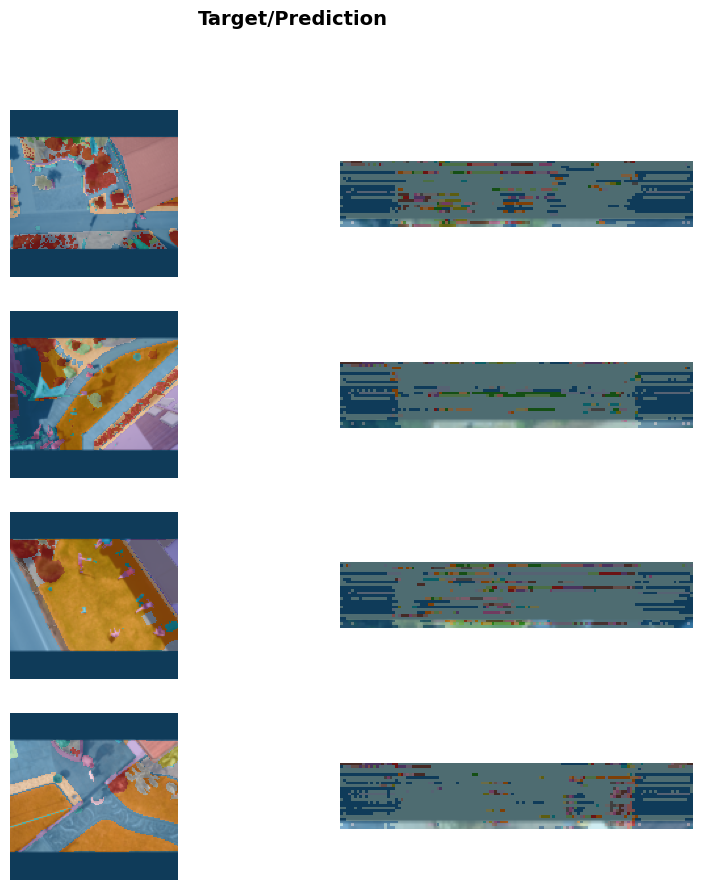

In [ ]:
learn.show_results(max_n=4, figsize=(10, 10))

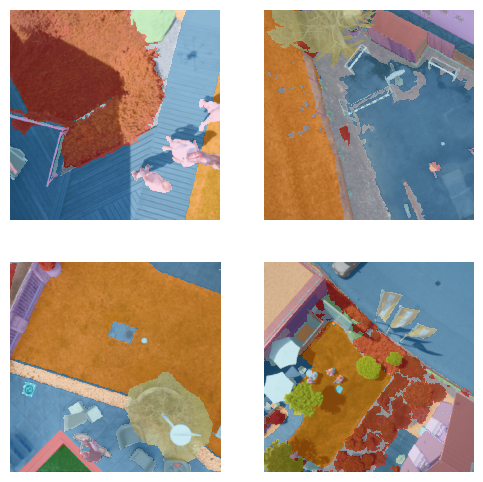

In [ ]:
dls = dblock.new(item_tfms=Resize(256)).dataloaders(image_path, bs=4)  # Resized to 256x256
dls.show_batch(max_n=6, vmin=0, vmax=len(codes)-1)

In [ ]:
learn.dls = dls
learn.fine_tune(8)

epoch,train_loss,valid_loss,dice,time
0,1.392150,1.335952,6.237286,15:56


epoch,train_loss,valid_loss,dice,time
0,1.037833,0.917899,6.894333,15:51
1,0.974455,1.123092,7.314030,15:54
2,1.006794,1.098785,7.212354,16:03
3,0.888611,0.809074,8.338049,15:57
4,0.822186,0.771719,7.732997,15:49
5,0.690998,0.694217,8.121112,15:53
6,0.612135,0.657251,8.311937,16:00
7,0.608397,0.665285,8.254667,16:01


The model is definitely learning something! Scores improved from the previosu run but still extremled garbled images (a little better though).

Time for 512x512 I thought!

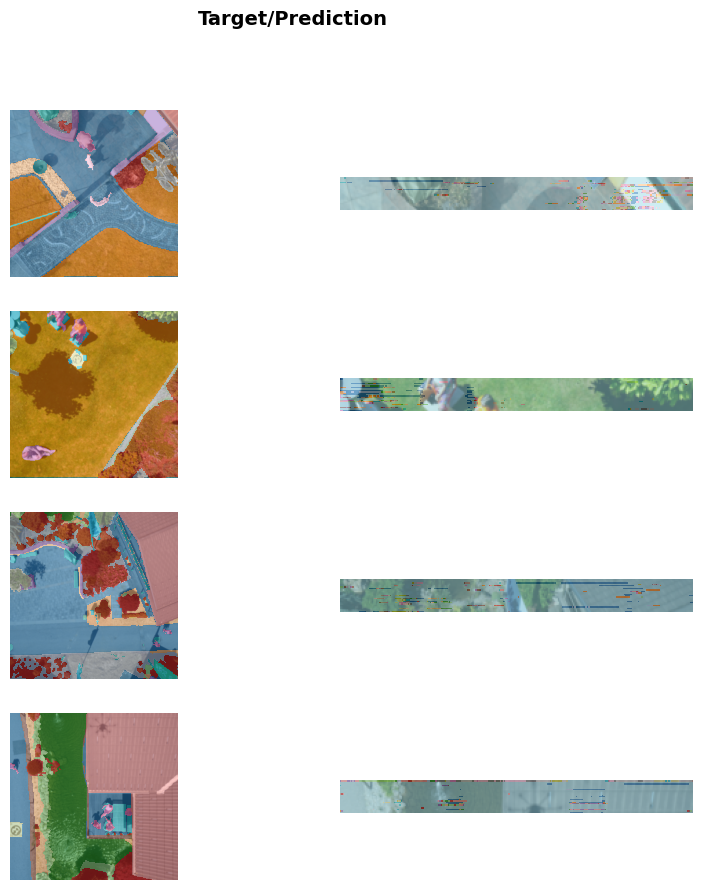

In [ ]:
learn.show_results(max_n=4, figsize=(10, 10))

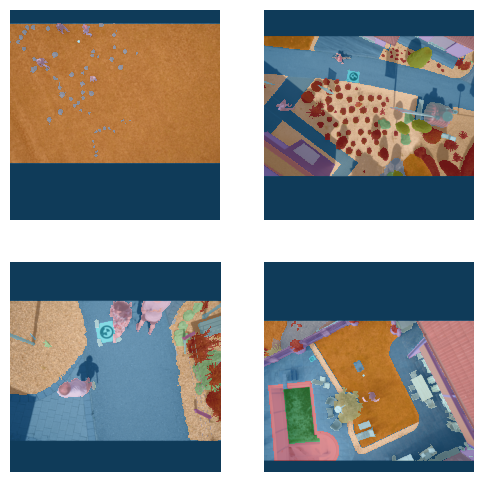

In [ ]:
dls = dblock.new(
    item_tfms=Resize(512, method='pad', pad_mode='zeros')  # Resized to 512x512
).dataloaders(image_path, bs=4)  # adjust if OOM

dls.show_batch(max_n=6, vmin=0, vmax=len(codes)-1)

In [ ]:
learn.dls = dls
learn.fine_tune(8)

epoch,train_loss,valid_loss,dice,time
0,0.796946,0.641491,7.300181,16:02


epoch,train_loss,valid_loss,dice,time
0,0.435273,0.461309,8.659556,16:00
1,0.426227,0.479297,9.013684,16:09
2,0.423315,0.579964,8.606385,16:11
3,0.430840,0.466223,8.117252,16:06
4,0.379368,0.406494,8.898525,16:07
5,0.317250,0.381038,9.030339,16:00
6,0.287430,0.378827,9.047316,16:05
7,0.271918,0.397177,9.098994,16:08


Best scores yet, but still poor output? I was really confused at this point. Why do the images look like that?

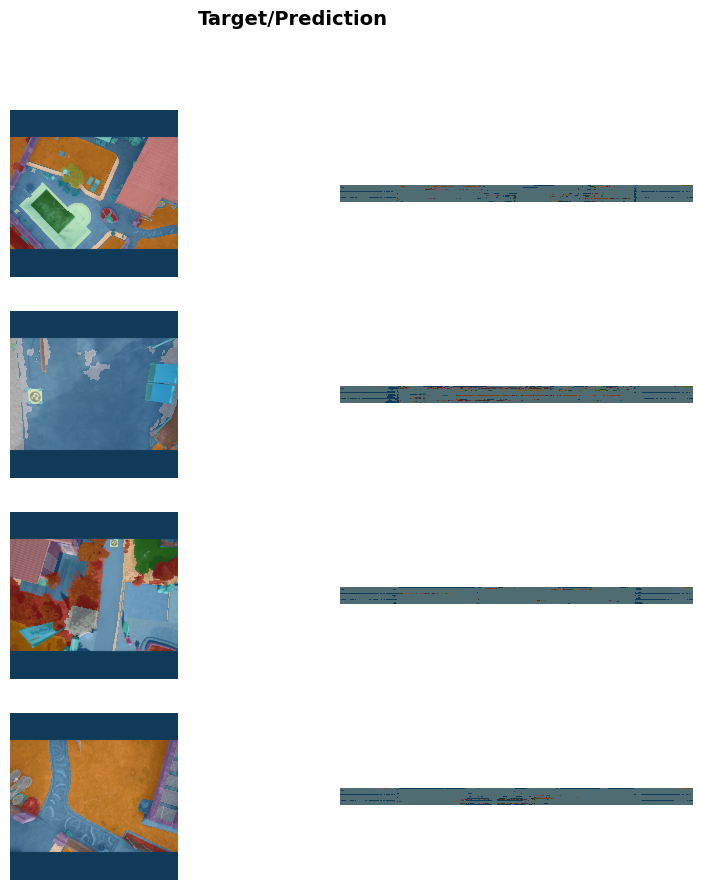

In [ ]:
learn.show_results(max_n=4, figsize=(10, 10))

After a bit of digging, i realized that I was not doing the same preprocessing at inference! So I proceed to pass a PILImage to the model to see if I get an appropriate output this time.

In [ ]:
img = PILImage.create(image_path/'056.jpg')
dl = learn.dls.test_dl([img])  # passes through same resizing/padding
preds = learn.get_preds(dl=dl)
pred_masks, _ = preds

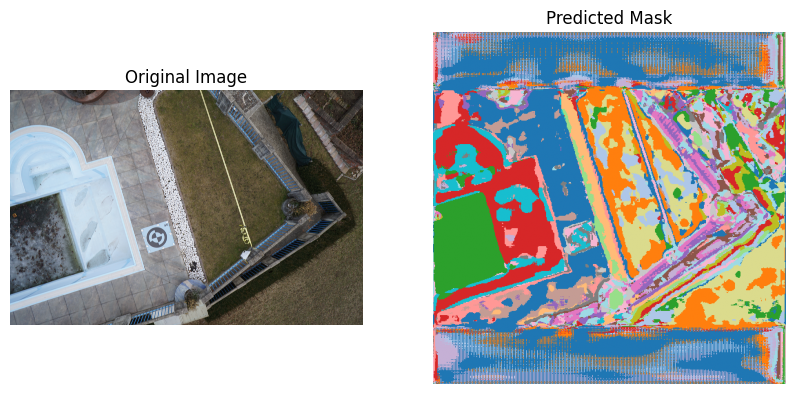

In [ ]:
pred_class = pred_masks[0].argmax(dim=0)  # (H, W) with class indices

# Original image
img = PILImage.create(image_path/'056.jpg')

# Predicted mask (convert to numpy for plotting)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(pred_class, cmap='tab20')  # or another colormap
plt.axis('off')
plt.title("Predicted Mask")
plt.show()

This what I had been looking for! While the model isn't doign the best(Dice ended up ~ 0.37), training the model at a higher resolution definitely made a difference to the output quality.